# CSCA 5632: Final Project - Unsupervised Anomaly Detection for Network Data



# Overview/Problem Description

Network security is an ever-present necessity for any computer network, whether it's used for providing services to the broader public over the Internet, or an isolated island network that has no external percieved threat. One technique for detecting security events is through the use of Intrusion Detection Systems (IDS), which use various methods to flag malicious network traffic.

Some IDS use anomaly detection to surface suspicious (anomalous) traffic on protected networks, which at a high level translates to detecting outliers compared to normal traffic patterns. In the realm of Machine Learning, this can be accomplished by training models (unsupervised) on normal traffic, then flagging anomalous traffic by detecting patterns that don't "fit" the trained model.

In this project, we will be training a very simple unsupervised model (autoencoder) that could be applied to the IDS scenario. The dataset that will be used is [Network Intrusion Detection](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection), which previously existed as a Kaggle dataset.  EDA will be used to determine the best approach for any data cleaning or transformations, then model bulding/training/analysis will be performed, followed by overall results and summary.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Additional imports.
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pd.set_option('display.max_columns', None)
keras.utils.set_random_seed(42)

/kaggle/input/network-intrusion-detection/Train_data.csv
/kaggle/input/network-intrusion-detection/Test_data.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/network-intrusion-detection/Train_data.csv')
df_test = pd.read_csv('/kaggle/input/network-intrusion-detection/Test_data.csv')

# EDA

We will first perform Exploratory Data Analysis to get a more detailed view of datasets, which will help guide any cleaning, preprocessing, and/or transformations that may be necessary for training and evaluation.

## EDA - High Level

We'll initially look at the high level shape and structure of the data:

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [4]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.0,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,18,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [5]:
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00
22540,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.00,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00
22541,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.00,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07
22542,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.00,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00


In [6]:
# Get disjunction between train and test columns.
set(df_train.columns.tolist()) ^ set(df_test.columns.tolist())

{'class'}

We have ~25k rows in the training set, and ~22k rows in the test set. The column counts are off by 1, and we can see that the disjunction of column names is the single `class` column. That matches expectations for a typical Kaggle competition dataset since the test data is usually unabeled in order to only allow scoring upon submission of the test data predictions. We also have a mix of numerical and categorical data.

Since we are performing unsupervised learning in this project, we'll exclude the `class` column for training and initial evaluation, but we can use it toward the end of the project notebook to get a true accuracy score. We will also completely exlude use of the test dataset because:
1. We will fit models to "normal" traffic patterns, which require the `class` label to filter out anomalous traffic.
2. Because the test dataset lacks labels, we wouldn't be able to use it for model evaluation.

## EDA - Numeric

We'll now focus on numerical columns to flesh out any that might be superfluous.

In [7]:
# df_train.dtypes.unique()
# df_train.dtypes
numeric_cols = df_train.select_dtypes(include=np.number).columns
object_cols = df_train.select_dtypes(include=object).columns

In [8]:
# describe() only targets numerical dtypes, so no need to explicitly filter.
df_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A couple of columns have a `std` of 0, so we'll dig into those as initial columns that can be ignored. We also note that the numerical values vary widely due to different types of measurements and different units (e.g. count vs. rate), which suggests the need for normalization (handled later on).

In [9]:
# training data columns with std of 0
df_train_std_0_cols = df_train[numeric_cols].columns[df_train[numeric_cols].std() == 0].tolist()

print(f'df_train std==0 columns: {df_train_std_0_cols}')

df_train std==0 columns: ['num_outbound_cmds', 'is_host_login']


`num_outbound_cmds` and `is_host_login` both contain all zeros, so we'll remove them now.

In [10]:
df_train = df_train.drop(columns=df_train_std_0_cols)
numeric_cols = numeric_cols.drop(df_train_std_0_cols)

Before exploring further, perform a final `NaN` check. `NaN`s can skew results or prevent certain types of models from training alltogether.

In [11]:
df_train.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_s

Now to delve further into the distribution of numeric data. We'll plot histograms and violin plots for each of the numeric columns below:

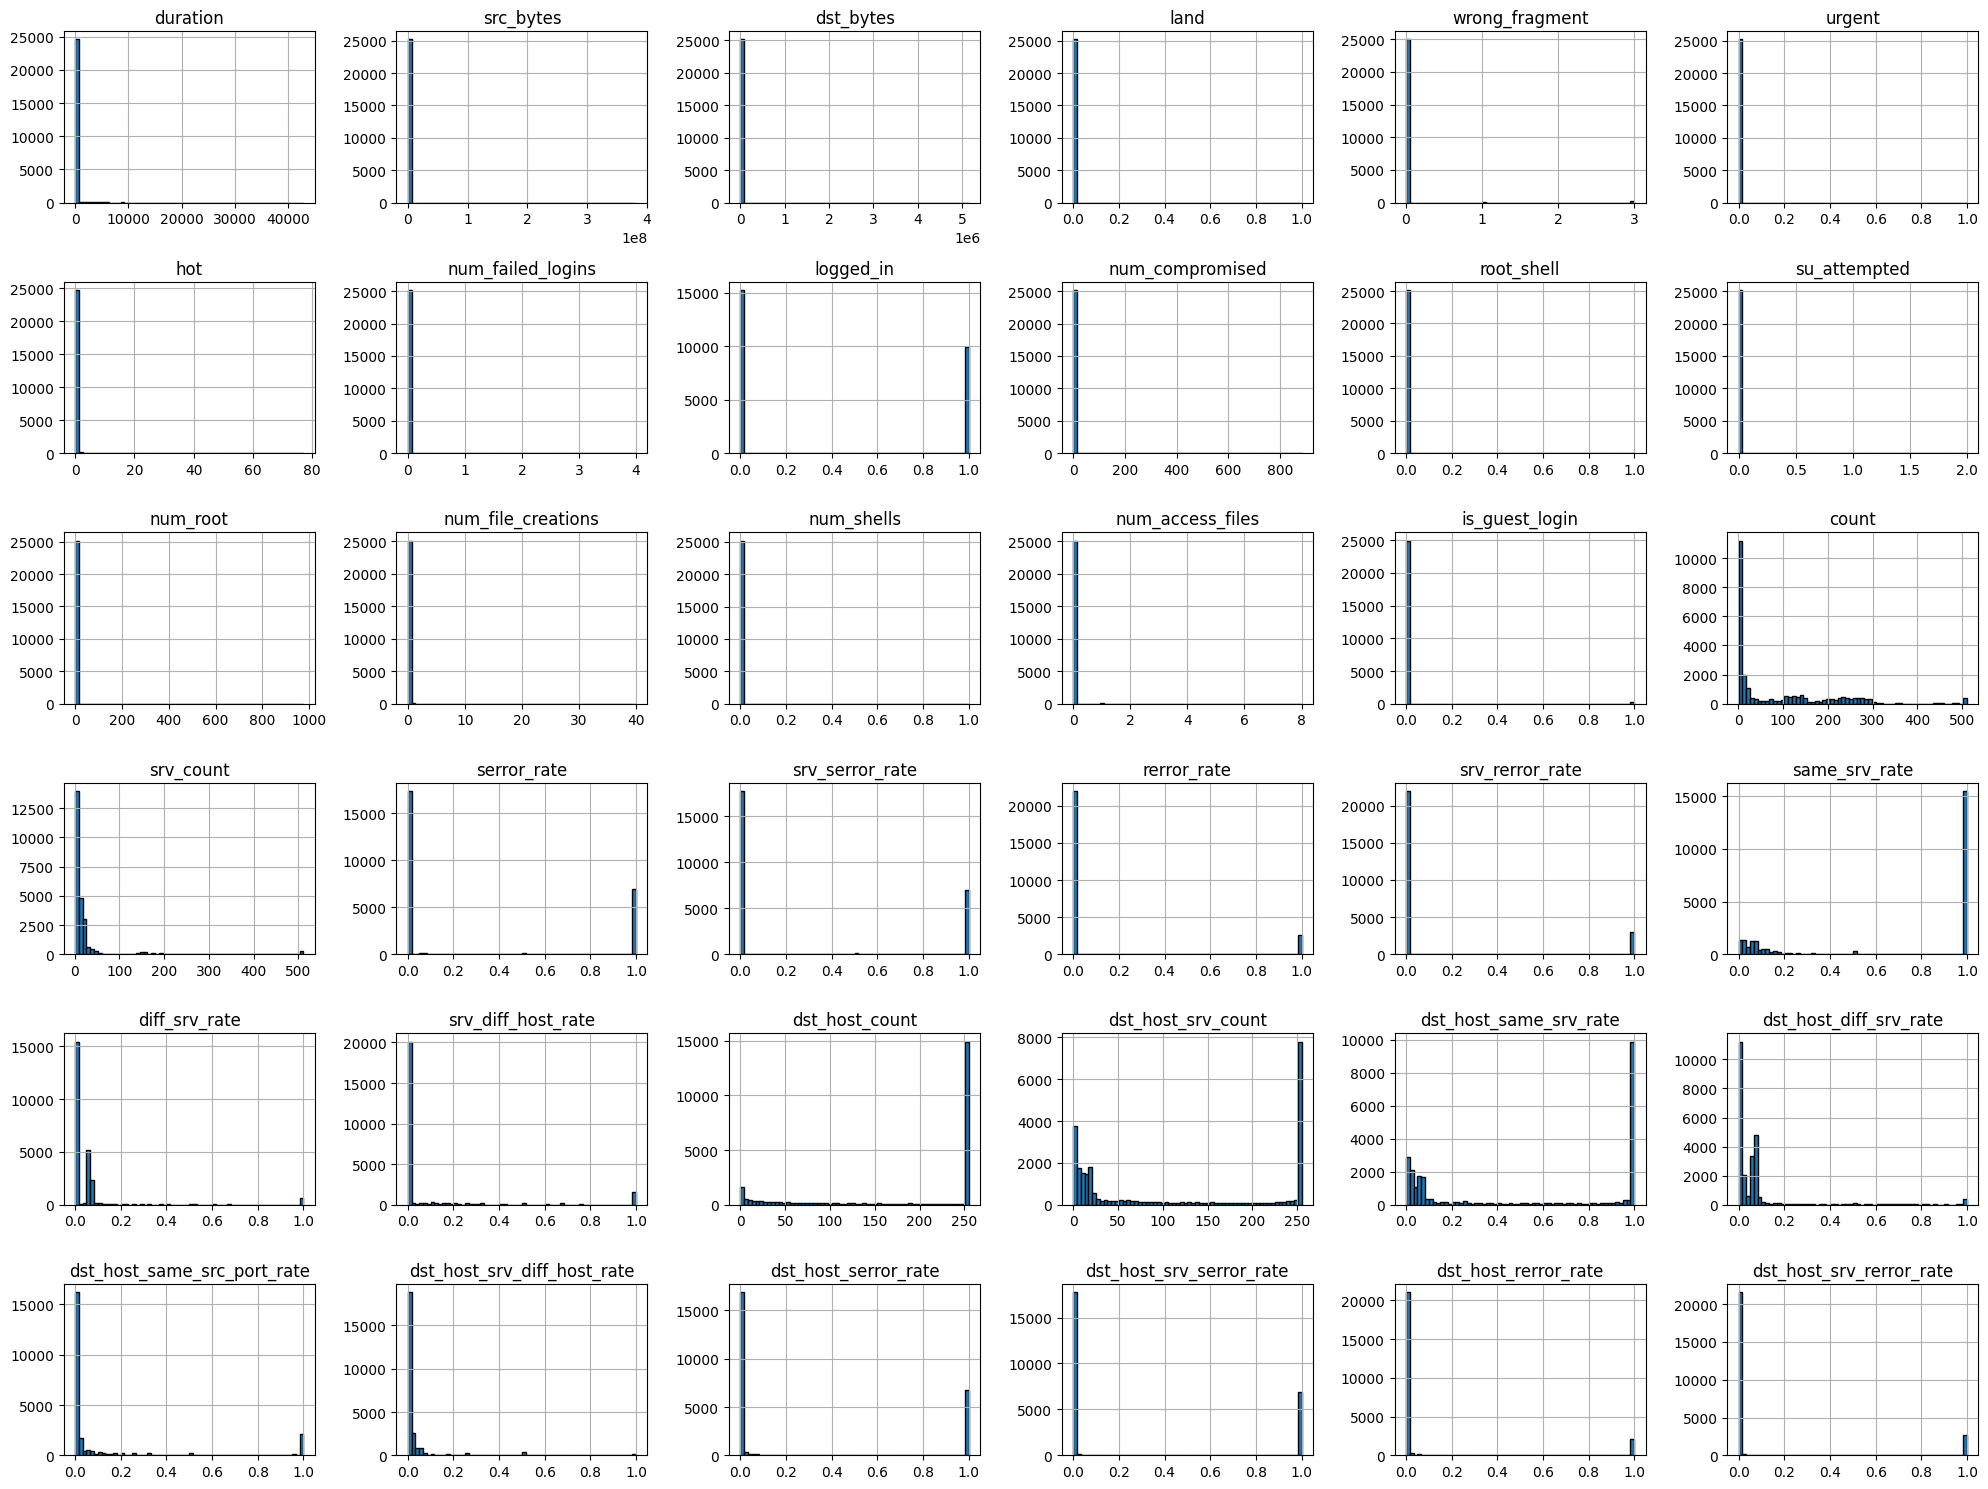

In [12]:
df_train[numeric_cols].hist(figsize=(20, 15), bins=60, edgecolor='black')
plt.tight_layout()
plt.show()

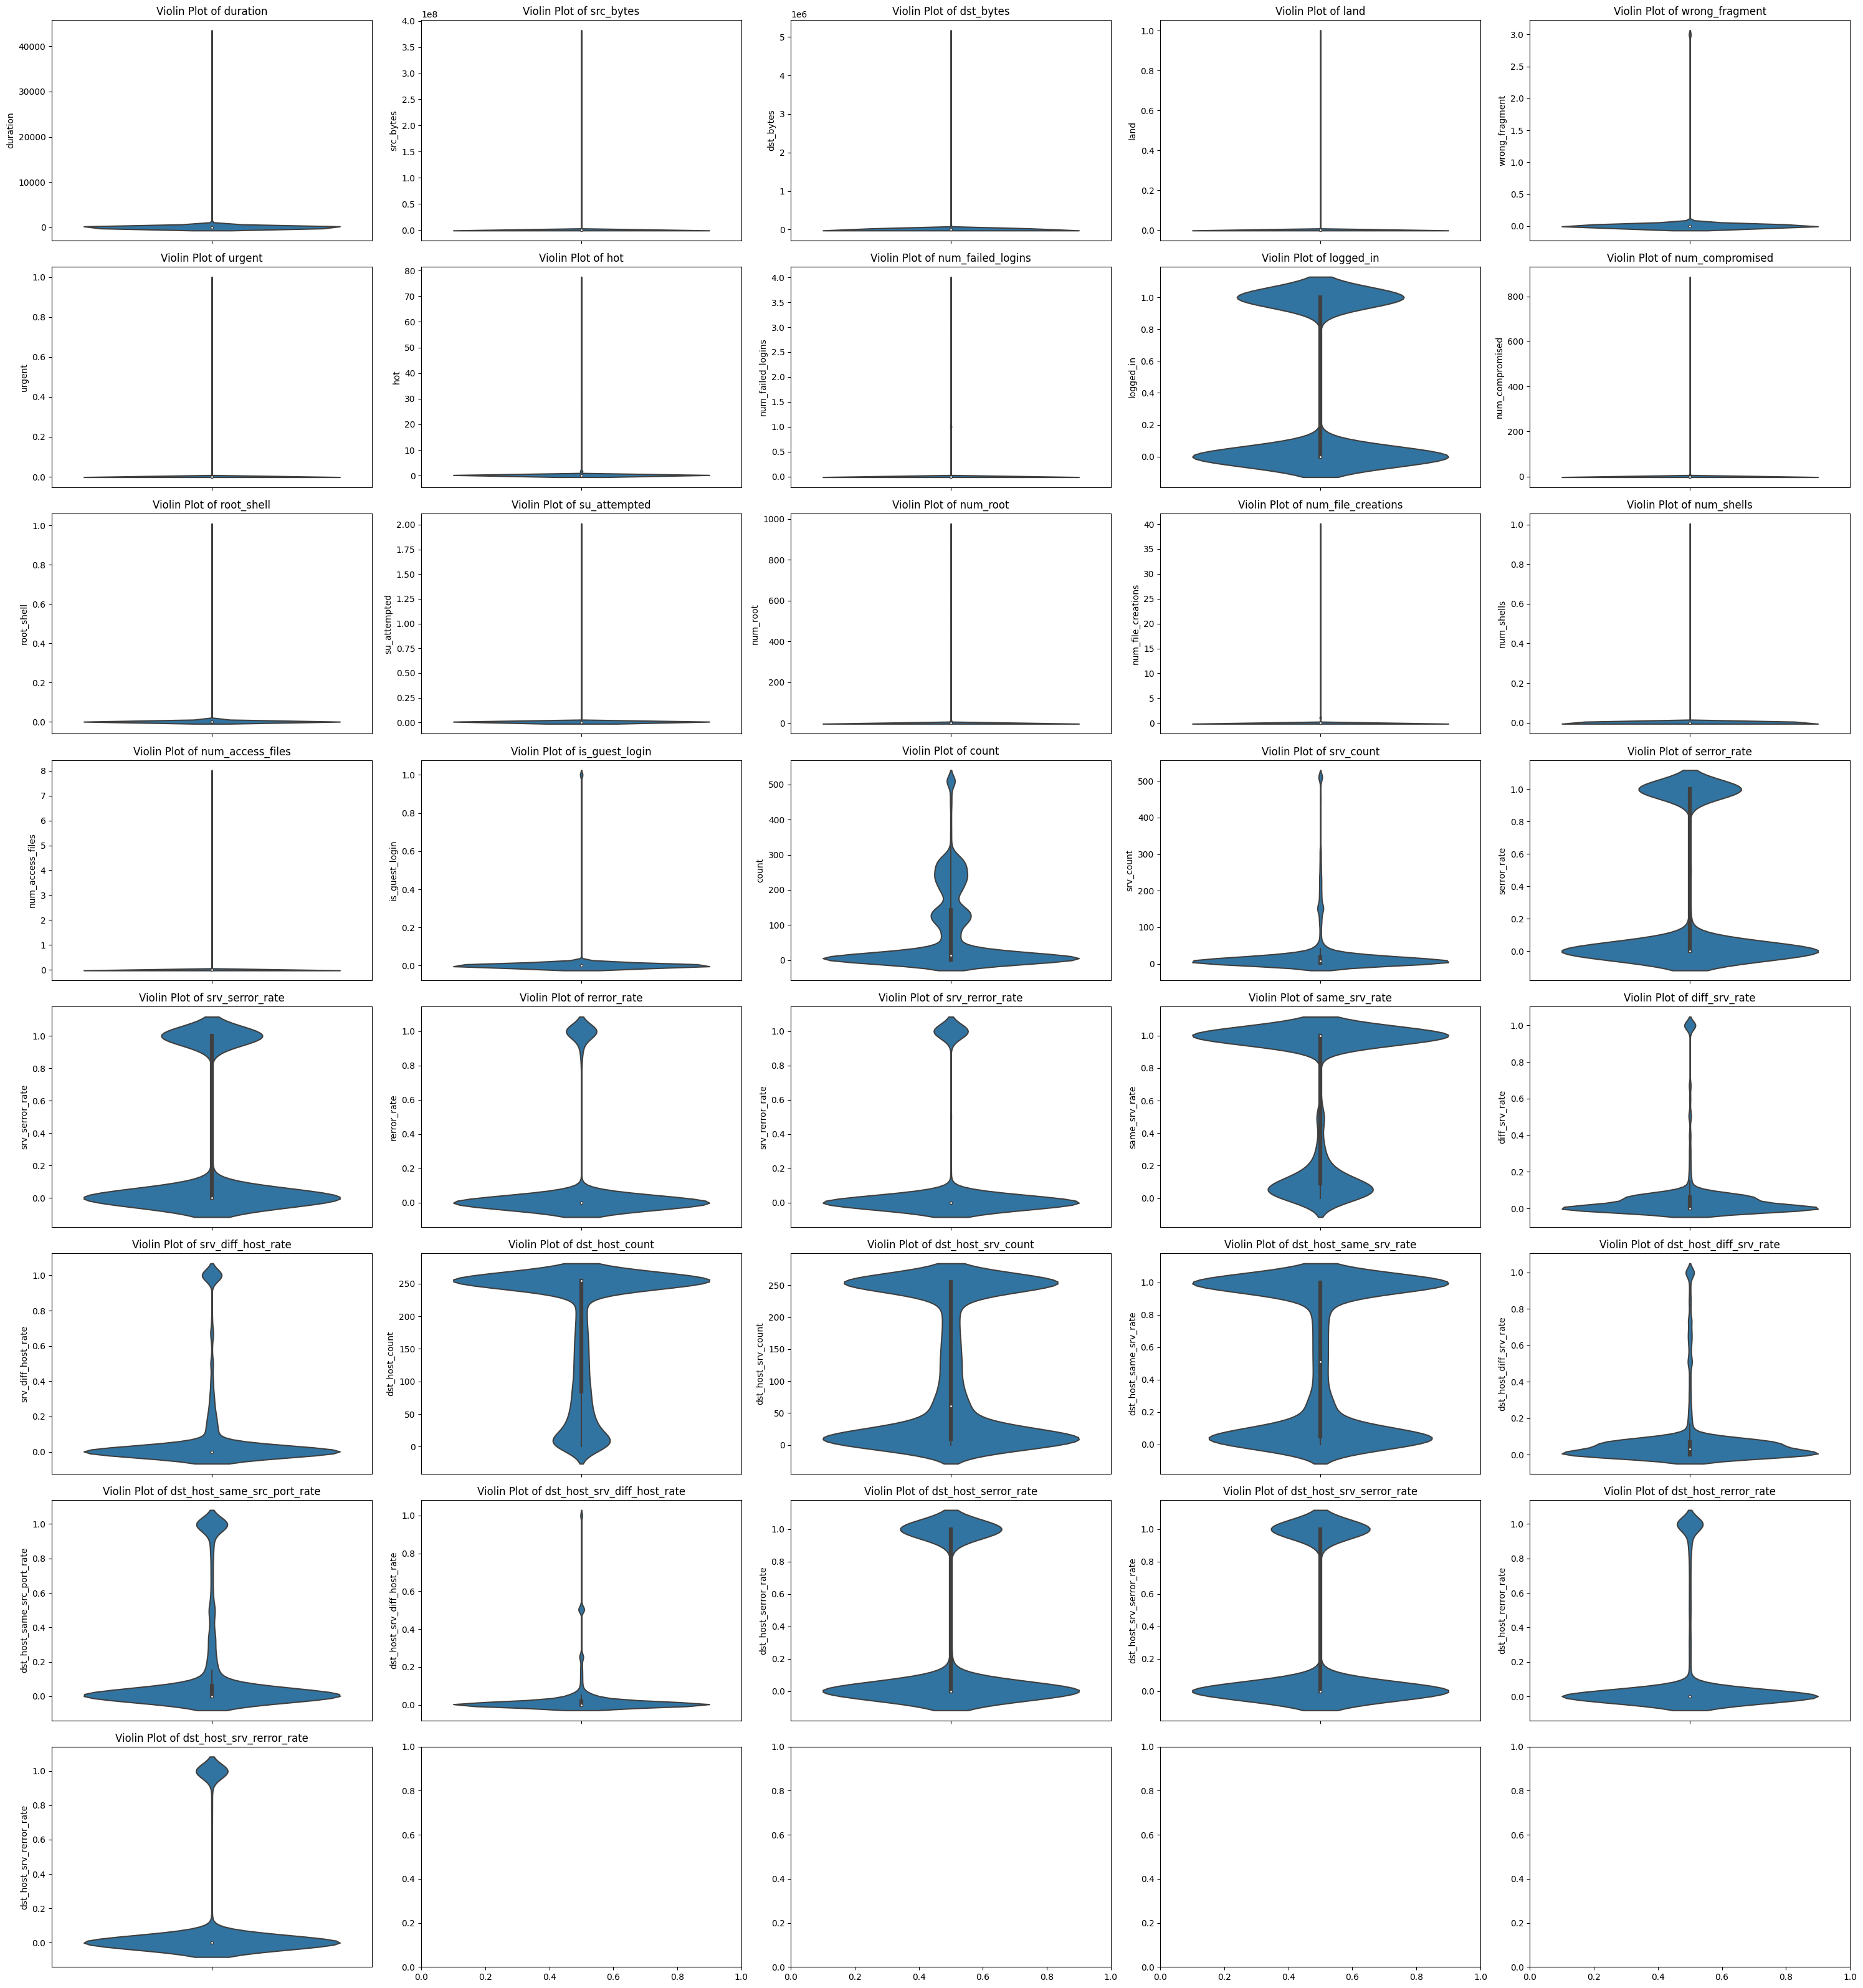

In [13]:
import math

num_numeric_cols = len(numeric_cols)
graph_cols = 5

fig, axes = plt.subplots(nrows=math.ceil(num_numeric_cols/graph_cols), ncols=graph_cols, figsize=(6 * graph_cols, 4 * math.ceil(num_numeric_cols/graph_cols)))
# print(f'axes: {axes}')

for ix, col in enumerate(numeric_cols):
    i = ix // graph_cols
    j = ix % graph_cols
    # print(f'i: {i}  j: {j}')
    sns.violinplot(y=df_train[col], ax=axes[i][j])
    axes[i][j].set_title(f"Violin Plot of {col}")
    axes[i][j].set_ylabel(col)

plt.tight_layout()
plt.show()

We can see from both the histograms and the violin plots most of the data is fairly skewed. Some of the count-based features are heavily concentrated at zero with just a few outliers. The range of values also highlights again that we'll want to normalize the data before training.

## EDA - Categorical

Similar to the numeric columns, we'll explor the categorical columns for any superfluous data or distributions that look strange.

Below we see that the `protocol_type` and header `flag` values look reasonable. There is a wide variety of `service` values, so we'll explore those more deeply in a table below.

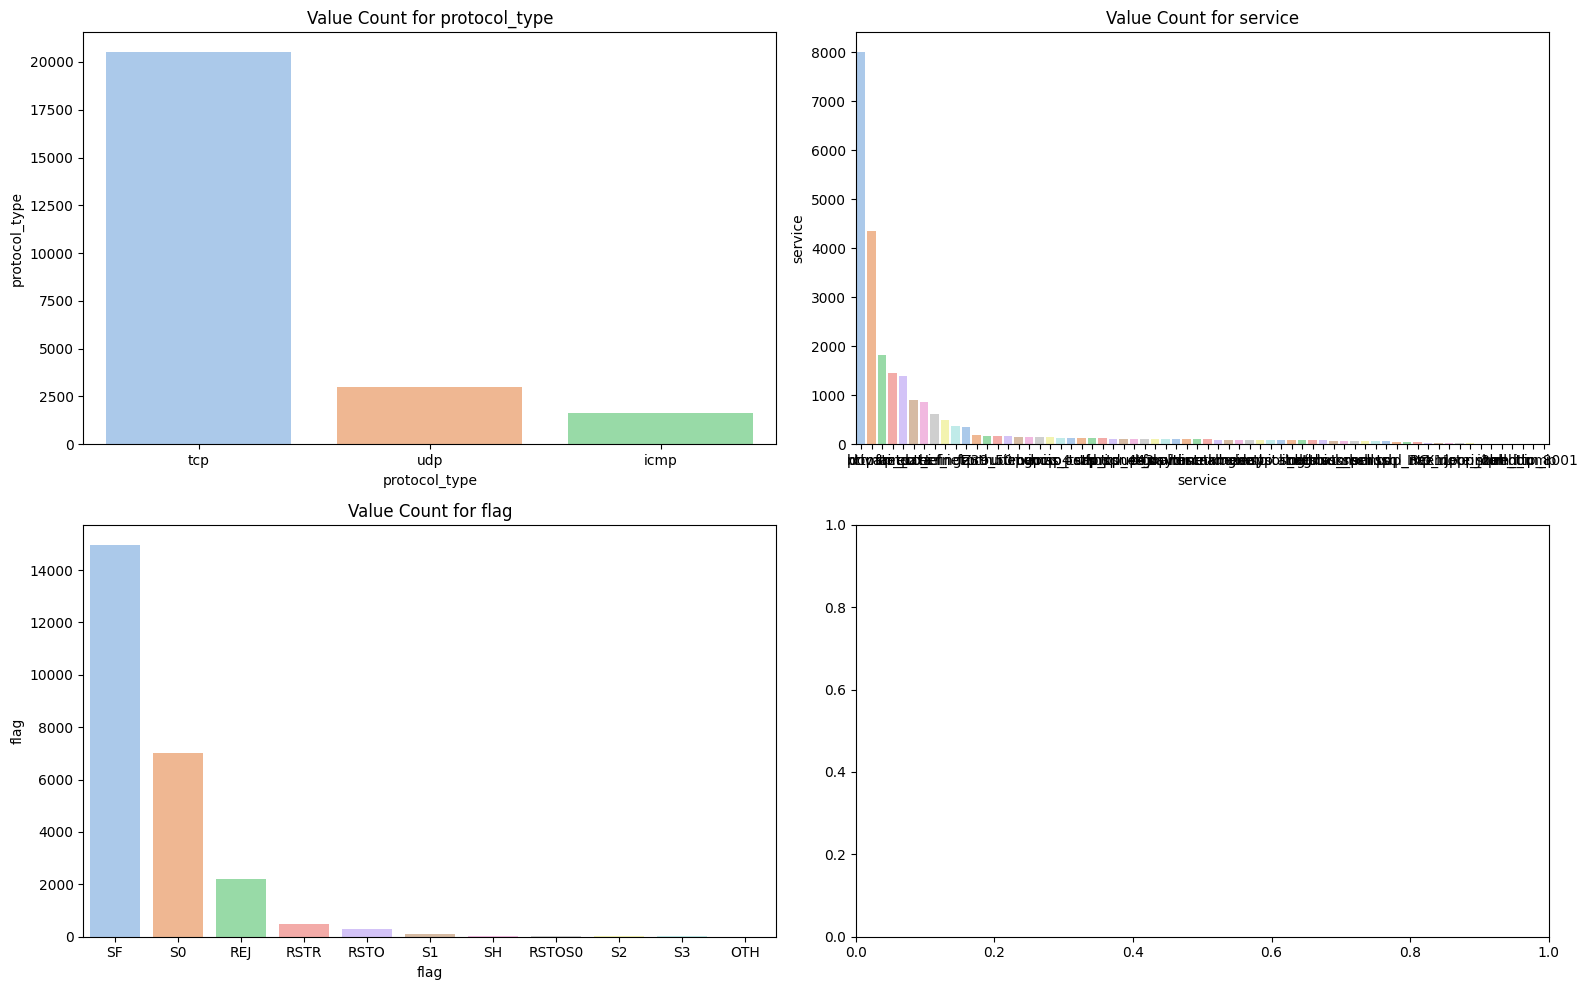

In [14]:
import math

num_categorical_cols = len(object_cols)
graph_cols = 2

fig, axes = plt.subplots(nrows=math.ceil(num_categorical_cols/graph_cols), ncols=graph_cols, figsize=(8 * graph_cols, 5 * math.ceil(num_categorical_cols/graph_cols)))
# print(f'axes: {axes}')

for ix, col in enumerate(object_cols.drop('class')): # Exclude 'class'
    i = ix // graph_cols
    j = ix % graph_cols
    value_counts = df_train[col].value_counts()
    # print(f'i: {i}  j: {j}')
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="pastel", ax=axes[i][j])
    axes[i][j].set_title(f"Value Count for {col}")
    axes[i][j].set_ylabel(col)

plt.tight_layout()
plt.show()

In [15]:
# print all "service" values
dmr = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
print(df_train['service'].value_counts())
pd.set_option('display.max_rows', dmr)

service
http           8003
private        4351
domain_u       1820
smtp           1449
ftp_data       1396
eco_i           909
other           858
ecr_i           613
telnet          483
finger          366
ftp             345
auth            189
Z39_50          172
courier         164
uucp            157
time            155
bgp             146
whois           145
imap4           138
uucp_path       133
iso_tsap        131
ctf             127
urp_i           124
nnsp            123
supdup          114
http_443        113
csnet_ns        111
efs             110
domain          109
gopher          109
daytime         107
vmnet           107
discard         105
hostnames        96
name             92
klogin           92
exec             91
ldap             90
mtp              90
systat           88
netbios_dgm      85
link             85
login            79
netstat          78
netbios_ns       76
netbios_ssn      67
sunrpc           67
kshell           67
echo             65
nntp        

The categories look reasonable for `service` as well, and it's particularly fun to see **gopher** show up!

Overall, it looks like the only preprocessing that will be required for the three categorical columns will be basic encoding (i.e., One-hot).

Finally, because we'll be training an autoencoder in an unsupervised fashion, we only want to use "normal" (non-anomylous) data for training so that it can be used to detect outliers as anomylous. Only our training dataset has labels, so we'll need to use that for training with the anomalous data masked out.

In [16]:
# Look at the possible values for "class"
df_train['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

In [17]:
# Create masks for "normal" and "anomaly" to allow stripping out anomaly rows for training (used below in Modeling)
df_train_normal_mask = df_train['class'] == 'normal'
df_train_anomaly_mask = df_train['class'] == 'anomaly'

# Modeling

In this section, we will move on to preprocessing based on the EDA above, followed by modeling and analysis.

## Preprocessing

As mentioned earlier, we'll be training an autoencoder, which only requires the "normal" data. Additionally, autoencoder training is unsupervised in the sense that ground-truth labels are not used. To prepare our data considering these requirements, we'll include the normal rows using the `df_train_normal_mask` created above and drop the `class` column.

Categorical columns will then be encoded using a `OneHotEncoder` and replaced with the resulting encoded columns and values.

Finally, numerical columns will be normalized using a `StandardScalar`.

In [18]:
# Create training dataset, composed of the loaded training set with "anomaly" rows removed
# and the "class" column removed.
X_train_normal = df_train[df_train_normal_mask].drop(columns=['class'])

In [19]:
# Encode categorical columns using a OneHotEncoder.
X_cat_cols = X_train_normal.select_dtypes(include=object).columns
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df_train[X_cat_cols]) # FIT on full data, but transform our filtered subset.
X_cats_data = ohe.transform(X_train_normal[X_cat_cols])

# Convert back to a dataframe using categories+values as column names.
X_cats_data_df = pd.DataFrame(X_cats_data, columns=ohe.get_feature_names_out(X_cat_cols))

In [20]:
X_cats_data_df

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13446,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [21]:
# Now replace the categorical columns with the one-hot encoded values.
X_train_normal = X_train_normal.drop(columns=X_cat_cols)
X_train_normal = pd.concat([X_train_normal, X_cats_data_df.set_index(X_train_normal.index)], axis=1)

In [22]:
# No more 'object' columns remain.
X_train_normal.select_dtypes(include=object).columns

Index([], dtype='object')

In [23]:
# Now normalize the numeric values using a StandardScaler.
sscaler = StandardScaler()
X_train_normal_scaled = sscaler.fit_transform(X_train_normal)

## Model Training

With data prepared, we're now ready to train the autoencoder.

The most basic autoencoder architecture is a neural network with some number of layers with the following properties:
* The input and output layer shapes are equal.
* The size of the hidden layers on the encoder side progressively funnel down to some minimum size. The smallest layer on the encoder side is the "bottleneck", which contains the latent space representation of the learned encoding.
* The size of the hidden layers on the decoder side progressively funnel up to the output layer size and shape.

A simple example could look like:

    Input -> 8 Neurons -> 4 Neurons -> 8 Neurons -> Output

The autoencoder is trained by minimizing the MSE, RMSE, or MAE between the input and output, where the input and output are the **same**. This trains the encoder side to essentially "compress" the input down to the size of the bottleneck (latent space), and trains the decoder side to reconstruct the input given the latent space representation.

In [24]:
input_dim = X_train_normal_scaled.shape[1]
autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid'),
])

autoencoder.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        'mean_squared_error',
        'cosine_similarity',
        'mean_absolute_error',
    ],
)

In [25]:
# Fit the autoencoder.
# es = keras.callbacks.EarlyStopping(patience=3)
# history = autoencoder.fit(X_train_normal_scaled, X_train_normal_scaled, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es], verbose=1)
history = autoencoder.fit(X_train_normal_scaled, X_train_normal_scaled, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - cosine_similarity: 0.0318 - loss: 0.7173 - mean_absolute_error: 0.4212 - mean_squared_error: 0.7173 - val_cosine_similarity: 0.4654 - val_loss: 0.5194 - val_mean_absolute_error: 0.1582 - val_mean_squared_error: 0.5194
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.4846 - loss: 0.5444 - mean_absolute_error: 0.1588 - mean_squared_error: 0.5444 - val_cosine_similarity: 0.5168 - val_loss: 0.5065 - val_mean_absolute_error: 0.1538 - val_mean_squared_error: 0.5065
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.5254 - loss: 0.5320 - mean_absolute_error: 0.1554 - mean_squared_error: 0.5320 - val_cosine_similarity: 0.5552 - val_loss: 0.4998 - val_mean_absolute_error: 0.1488 - val_mean_squared_error: 0.4998
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - cosine_similarity: 0.5591 - loss: 0.5265 - mean_absolute_error: 0.1507 - mean_squared_error: 0.5265 - val_cosine_similarity: 0.562

The training history is plotted below for `loss`, `mse`, `mae`, and `cosine_similarity` per iteration (epoch). The model converges pretty rapidly within about 5 iterations, then continues with small incremental improvements up to the final 50th iteration. If we were using an extremely large dataset that required 10's of minutes or more for a single iteration, it could be argued that using an early stopping trigger might be beneficial to save on compute. However, that would require more analysis of the resulting model with respect to the requirements of network IDS.

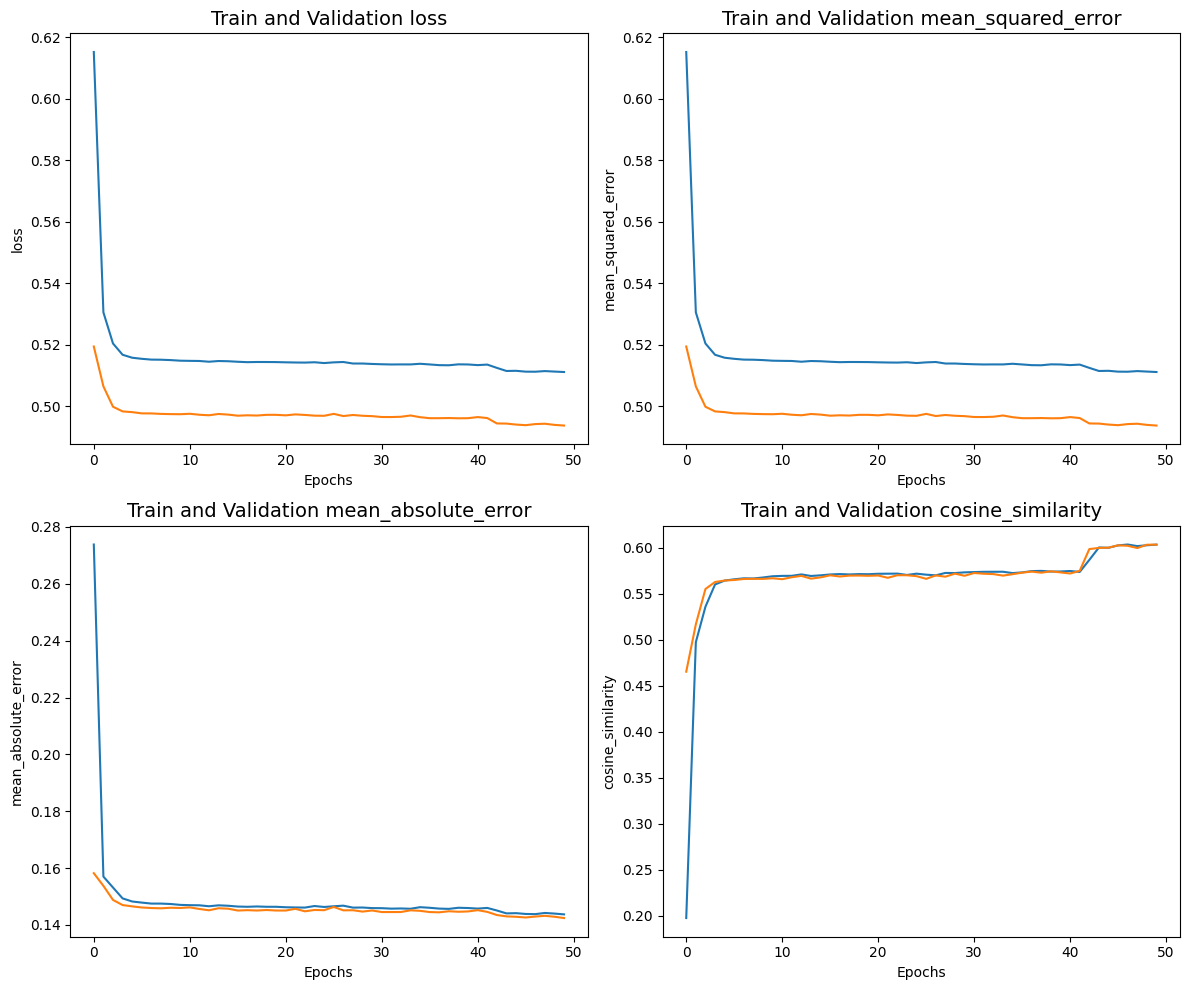

In [26]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Modified plot_result from https://keras.io/examples/nlp/multi_label_classification/#train-the-model
def plot_result(item, ax):
    # plt.plot(history.history[item], label=item)
    # plt.plot(history.history["val_" + item], label="val_" + item)
    sns.lineplot(history.history[item], ax=ax)
    sns.lineplot(history.history['val_' + item], ax=ax)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(item)
    ax.set_title("Train and Validation {}".format(item), fontsize=14)
    # plt.legend()
    # plt.grid()
    # plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6 * 2, 5 * 2))

plot_result('loss', axes[0][0])
plot_result('mean_squared_error', axes[0][1])
plot_result('mean_absolute_error', axes[1][0])
plot_result('cosine_similarity', axes[1][1])

plt.tight_layout()
plt.show()

## Model Analysis

We can now move on to analyzing the performance of the trained model.

Using the most simple method for categorizing a sample input as `anomaly` is to look for predicted results with an MSE that is larger than the baseline MSE of the model for all `normal` samples. We calculate this below.

In [27]:
# Reconstruct data and compute reconstruction error of the training data.
reconstructed = autoencoder.predict(X_train_normal_scaled)
# mse = np.mean(np.power(X_train_normal_scaled - reconstructed, 2), axis=1)
mse = np.mean(np.power(X_train_normal_scaled - reconstructed, 2))

print(f'Training MSE: {mse:.3f}')

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training MSE: 0.508


Now with the baseline MSE, we can run predictions on the full training dataset (which includes both `normal` and `anomaly` samples) and flag any MSEs greater than baseline as `anomaly`. For the purposes of computing performance metrics, `normal` will be encoded as 0, and `anomaly` as 1.

To prepare the full training dataset for inference, we must first apply the previously fit `OneHotEncoder` and `StandardScalar`. Predictions (reconstruction of the original inputs) are then compared against the baseline MSE to find `anomaly` samples. Finally, we compute and print some performance metrics.

In [28]:
# Compare against known labels in the training dataset to calculate model performance.
from sklearn.metrics import classification_report

test_df = df_train.copy()
true_labels = (df_train_anomaly_mask).astype(int)
test_df = test_df.drop(columns=['class'])

# Apply same preprocessing to test data
test_categorical_data = ohe.transform(test_df[X_cat_cols])
test_categorical_df = pd.DataFrame(test_categorical_data, columns=ohe.get_feature_names_out(X_cat_cols))
test_df = test_df.drop(columns=X_cat_cols)
test_df = pd.concat([test_df, test_categorical_df.set_index(test_df.index)], axis=1)
test_scaled = sscaler.transform(test_df)

# Run through autoencoder and calculate anomalies
test_reconstructed = autoencoder.predict(test_scaled)
test_mse = np.mean(np.power(test_scaled - test_reconstructed, 2), axis=1)
test_threshold = mse
test_predictions = (test_mse > test_threshold).astype(int)

# Compute performance metrics
print(classification_report(true_labels, test_predictions, target_names=['normal', 'anomaly']))

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

      normal       0.97      0.81      0.89     13449
     anomaly       0.82      0.98      0.89     11743

    accuracy                           0.89     25192
   macro avg       0.90      0.89      0.89     25192
weighted avg       0.90      0.89      0.89     25192



Using the simple baseline MSE threshold, the model turns out to perform pretty well with detecting `anomaly` samples at 98% recall. However, precision _might_ be considered low at 82%, meaning there were 18% false-positives. Depending on the situation, that might be acceptable if flagging an anomaly is more important than receiving some rate of false alerts. Overall, the F1 score of 0.89 indicates a relatively good balance between precision and recall.

If the requirement of the given IDS was to balance precision and recall, we could find the MSE threshold that maximizes the F1-score and examine the classification report again to compare with the system requirements (see below).

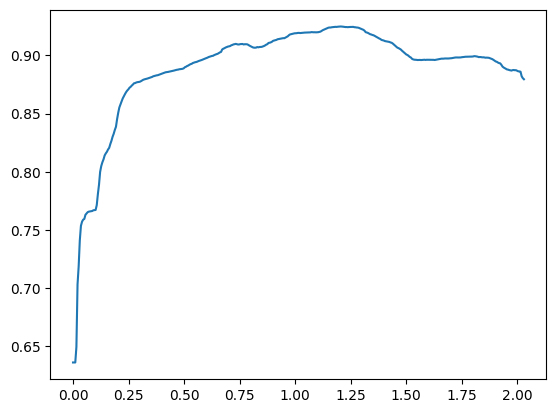

In [29]:
X = []
Y = []
for i in np.linspace(0, 4, 400):
    tt = i * mse
    tp = (test_mse > tt).astype(int)
    a = f1_score(true_labels, tp)
    X.append(tt)
    Y.append(a)
sns.lineplot(x=X, y=Y)
plt.show()

In [30]:
print(f'Max F1 (MSE threshold: {X[np.argmax(Y)]:.3f}): {np.max(Y)}')

Max F1 (MSE threshold: 1.206): 0.9249496306245802


In [31]:
test_threshold = 1.201
test_predictions = (test_mse > test_threshold).astype(int)

# Compute performance metrics
print(classification_report(true_labels, test_predictions, target_names=['normal', 'anomaly']))

              precision    recall  f1-score   support

      normal       0.94      0.92      0.93     13449
     anomaly       0.91      0.94      0.92     11743

    accuracy                           0.93     25192
   macro avg       0.93      0.93      0.93     25192
weighted avg       0.93      0.93      0.93     25192



# Conclusion

Using an autoencoder as an anomaly/outlier detection system is relatively straightforward. We were able to train the autoencoder neural network quickly using the preprocessed data that included only `normal` traffic samples, then flag `anomaly` samples by simply looking for reconstruction MSE higher than the baseline MSE (for `normal` samples).

The architecture of our autoencoder was very simple, consisting of 64 input/output neurons and a 16 neuron bottleneck. Other sizes and shapes may perform better or worse and could have different training and inference resource requirements, so further analysis would be required to determine the best fit for a given use case. This [paper](https://www.sciencedirect.com/science/article/pii/S2666827024000483) also has detailed information on different types of autoencoders for anomaly detection.

Our baseline autoencoder performed very well on the anomaly detection front with 98% recall, but had a potentially less desirable 82% precision. Again, depending on the use case and requirements of the IDS, more tuning could be performed (e.g., our example of maximizing for F1 score).

# References

* https://pandas.pydata.org/docs/user_guide/10min.html (and other Pandas docs)
* https://www.sciencedirect.com/science/article/pii/S2666827024000483
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://seaborn.pydata.org/
* https://www.geeksforgeeks.org/recovering-feature-names-of-explainedvarianceratio-in-pca-with-sklearn/
* https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879